In [3]:
import sys
sys.executable

'/usr/bin/python3'

In [4]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
import pandas as pd
# import config

In [5]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [7]:
dataset_name = 'ESC-50'
num_classes=50
Sound_database =  '/content/drive/My Drive/Datasets_new/'
DATASET_PATH = '/content/drive/My Drive/Datasets_new/{}'.format(dataset_name)
FEATURES_PATH= '/content/drive/My Drive/Mim_model_1_hls4ml/{}'.format(dataset_name)
MODEL_PATH= '/content/drive/My Drive/Mim_model_1_hls4ml/{}'.format(dataset_name)

In [26]:
import os
os.listdir(Sound_database)

['ESC-10-20210212T132948Z-001.zip',
 'BDLib-20210511T072013Z-001.zip',
 'ESC-10',
 'data',
 'models',
 'UrbanSound',
 'BDLib',
 'ESC-50']

In [ ]:
# NR_OF_THREADS = 4  # TODO
# SOUND_LIBRARIES = ["BDLiB-v2", "ESC-10", "urbansoundNormal"]
#SOUND_LIBRARIES = ["ESC-10"]
#SOUND_LIBRARIES = ["BDLib"]
SOUND_LIBRARIES = ["ESC-50"]
# SOUND_LIBRARIES = ["UrbanSound"]
#SOUND_LIBRARIES = ["small_UrbanSound"]
#SOUND_LIBRARIES = ["UrbanSound_testdata"]



In [25]:
for dataset_name in SOUND_LIBRARIES:
  print(dataset_name)

NameError: ignored

In [ ]:
for dataset_name in SOUND_LIBRARIES:
  DATASET_PATH = Sound_database+dataset_name
  print(DATASET_PATH)

/content/drive/My Drive/Datasets_new/ESC-10


In [ ]:
##Return audio features 
def feature_extraction(file_name):
    X, sample_rate = librosa.load(file_name,sr=44100,duration=5)
    if X.ndim > 1:
        X = X[:,0]
    X = X.T
    
    # Get features   
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0) #40 values
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0) #tonal centroid features
    
    ##Return computed features
    return mfccs, chroma, mel, contrast, tonnetz

In [ ]:
# Process audio files: Return arrays with features and labels
def parse_audio_files(parent_dir, sub_dirs, file_ext='*.wav'): ## .ogg audio format
    features, labels = np.empty((0,193)), np.empty(0) # 193 features total. This can vary
    
    for label, sub_dir in enumerate(sub_dirs): ##The enumerate() function adds a counter to an iterable.
        for file_name in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)): ##parent is data, sub_dirs are the classes
            try:
                mfccs, chroma, mel, contrast, tonnetz = feature_extraction(file_name)
            except Exception as e:
                print("[Error] there was an error in feature extraction. %s" % (e))
                continue
                
            extracted_features = np.hstack([mfccs,chroma, mel, contrast, tonnetz]) #Stack arrays in sequence horizontally (column wise)
            features = np.vstack([features, extracted_features]) #Stack arrays in sequence vertically (row wise).
            labels = np.append(labels, label)
        print("Extracted features from %s, done" % (sub_dir))
    return np.array(features), np.array(labels, dtype = np.int) ## arrays with features and corresponding labels for each audio

In [8]:
def one_hot_encode(labels): ##Check this hot encode
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels, n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [9]:
# Read sub-directories (audio classes)
audio_directories = os.listdir(DATASET_PATH)
audio_directories.sort()
print('Audio Classes: ', audio_directories)

Audio Classes:  ['101 - Dog', '102 - Rooster', '103 - Pig', '104 - Cow', '105 - Frog', '106 - Cat', '107 - Hen', '108 - Insects', '109 - Sheep', '110 - Crow', '201 - Rain', '202 - Sea waves', '203 - Crackling fire', '204 - Crickets', '205 - Chirping birds', '206 - Water drops', '207 - Wind', '208 - Pouring water', '209 - Toilet flush', '210 - Thunderstorm', '301 - Crying baby', '302 - Sneezing', '303 - Clapping', '304 - Breathing', '305 - Coughing', '306 - Footsteps', '307 - Laughing', '308 - Brushing teeth', '309 - Snoring', '310 - Drinking - sipping', '401 - Door knock', '402 - Mouse click', '403 - Keyboard typing', '404 - Door - wood creaks', '405 - Can opening', '406 - Washing machine', '407 - Vacuum cleaner', '408 - Clock alarm', '409 - Clock tick', '410 - Glass breaking', '501 - Helicopter', '502 - Chainsaw', '503 - Siren', '504 - Car horn', '505 - Engine', '506 - Train', '507 - Church bells', '508 - Airplane', '509 - Fireworks', '510 - Hand saw']


In [ ]:
##Get labels and features
if dataset_name == 'ESC-10':
  file_ext = '*.ogg' ## .ogg audio format
else:
  file_ext = '*.wav' ## .wav audio format
features, labels = parse_audio_files(DATASET_PATH, audio_directories,file_ext) #(parent dir,sub dirs,file_ext)

Extracted features from Airplane, done
Extracted features from Alarms, done


KeyboardInterrupt: ignored

In [10]:
np.save(FEATURES_PATH+'/feat.npy',features) ##NumPy array file created. Files are binary files to store numpy arrays
np.save(FEATURES_PATH+'/label.npy',labels)

NameError: ignored

In [11]:
# Label integer encoding 
labels = np.load(FEATURES_PATH+'/label.npy') # 10 labels total
features = np.load(FEATURES_PATH+'/feat.npy')
print(labels)
print(len(features))

[ 0  0  0 ... 49 49 49]
2000


In [12]:
# For future label de-encoding
if dataset_name == 'ESC-10':
  label_classes = np.array(['Baby_cry', 'Chainsaw', 'Clock_tick', 'Dog_bark', 'Fire_crackling', 'Helicopter', 'Person_sneeze', 'Rain', 'Rooster', 'Sea_waves'])
  print(label_classes)
elif dataset_name == 'UrbanSound':
  label_classes = np.array(['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music'])
  print(label_classes)
elif dataset_name == 'BDLib':
  label_classes = np.array(['airplane', 'alarms', 'applause', 'birds', 'dogs', 'motorcycles', 'rain', 'rivers', 'seawaves', 'thunders'])
  print(label_classes)
elif dataset_name =='ESC-50':
  label_classes = np.array(['101 - Dog', '102 - Rooster', '103 - Pig', '104 - Cow', '105 - Frog', '106 - Cat', '107 - Hen', '108 - Insects', '109 - Sheep', '110 - Crow', '201 - Rain', '202 - Sea waves', '203 - Crackling fire', '204 - Crickets', '205 - Chirping birds', '206 - Water drops', '207 - Wind', '208 - Pouring water', '209 - Toilet flush', '210 - Thunderstorm', '301 - Crying baby', '302 - Sneezing', '303 - Clapping', '304 - Breathing', '305 - Coughing', '306 - Footsteps', '307 - Laughing', '308 - Brushing teeth', '309 - Snoring', '310 - Drinking - sipping', '401 - Door knock', '402 - Mouse click', '403 - Keyboard typing', '404 - Door - wood creaks', '405 - Can opening', '406 - Washing machine', '407 - Vacuum cleaner', '408 - Clock alarm', '409 - Clock tick', '410 - Glass breaking', '501 - Helicopter', '502 - Chainsaw', '503 - Siren', '504 - Car horn', '505 - Engine', '506 - Train', '507 - Church bells', '508 - Airplane', '509 - Fireworks', '510 - Hand saw'])
  print(label_classes)


['101 - Dog' '102 - Rooster' '103 - Pig' '104 - Cow' '105 - Frog'
 '106 - Cat' '107 - Hen' '108 - Insects' '109 - Sheep' '110 - Crow'
 '201 - Rain' '202 - Sea waves' '203 - Crackling fire' '204 - Crickets'
 '205 - Chirping birds' '206 - Water drops' '207 - Wind'
 '208 - Pouring water' '209 - Toilet flush' '210 - Thunderstorm'
 '301 - Crying baby' '302 - Sneezing' '303 - Clapping' '304 - Breathing'
 '305 - Coughing' '306 - Footsteps' '307 - Laughing'
 '308 - Brushing teeth' '309 - Snoring' '310 - Drinking - sipping'
 '401 - Door knock' '402 - Mouse click' '403 - Keyboard typing'
 '404 - Door - wood creaks' '405 - Can opening' '406 - Washing machine'
 '407 - Vacuum cleaner' '408 - Clock alarm' '409 - Clock tick'
 '410 - Glass breaking' '501 - Helicopter' '502 - Chainsaw' '503 - Siren'
 '504 - Car horn' '505 - Engine' '506 - Train' '507 - Church bells'
 '508 - Airplane' '509 - Fireworks' '510 - Hand saw']


In [13]:
#Pandas dataframe with 193 features variables for each audio
df = pd.DataFrame(features)
# Add a new column for class (label), this is our target (in the first column)
# df.insert(loc=0,column='Audio_class',value=pd.Categorical.from_codes(labels, label_classes))
df['Audio class'] = pd.Categorical.from_codes(labels, label_classes)

df = df.drop_duplicates()
print(df['Audio class'])

0            101 - Dog
1            101 - Dog
2            101 - Dog
3            101 - Dog
4            101 - Dog
             ...      
1995    510 - Hand saw
1996    510 - Hand saw
1997    510 - Hand saw
1998    510 - Hand saw
1999    510 - Hand saw
Name: Audio class, Length: 2000, dtype: category
Categories (50, object): ['101 - Dog', '102 - Rooster', '103 - Pig', '104 - Cow', ...,
                          '507 - Church bells', '508 - Airplane', '509 - Fireworks', '510 - Hand saw']


In [14]:
df.shape

(2000, 194)

In [15]:
import numpy as np
import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D,Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
import time

In [ ]:
# # Load data 
# X = np.load("feat.npy")
# y = np.load('label.npy').ravel()

In [16]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
df['audios_classes'] = ord_enc.fit_transform(df[['Audio class']])

In [18]:
X = df.iloc[:,:193]
y = df.iloc[:,194:195]

In [19]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
X[:] = (df.iloc[:,:193])
# = MinMaxScaler((-127, 127)).fit_transform(a)
# scaler = StandardScaler().fit_transform(X)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3051: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer(key, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3036: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 233)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 233)
print(X_test)

            0           1          2    ...       190       191       192
405 -303.279633  123.692001   1.397406  ...  0.018478  0.008797  0.013065
819 -394.952240  202.223984 -40.121258  ... -0.101194 -0.026795  0.031908
658 -439.853577   24.449118  -4.287499  ...  0.017489  0.005912  0.003508
466 -371.169037  133.129059  24.169533  ... -0.058729 -0.002263  0.017213
441 -340.465485  145.022522 -24.417566  ...  0.043691 -0.002580 -0.020253
..          ...         ...        ...  ...       ...       ...       ...
812 -253.099884  172.666794 -36.601990  ... -0.021903 -0.000583  0.008121
494 -182.387894   42.150036 -57.186993  ...  0.015200 -0.009876  0.014467
232 -375.712311  103.893768  -0.619457  ...  0.027746 -0.000704  0.005603
258 -229.295364  200.417114 -69.564735  ...  0.002016  0.002796  0.004621
10  -425.241852  154.154831 -16.629791  ... -0.153493 -0.020825 -0.054902

[185 rows x 193 columns]


In [ ]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=7)
cvscores = []
Prediction_time_liste = []
fold = 0
model_nr=0
for train, test in kf.split(X,y):#scaler = X
    fold+=1
    print(f"Fold #{fold}")
        
#     X_train = X.to_numpy()[train]
    X_train =  X.to_numpy()[train]
    y_train = y.to_numpy()[train]
    X_test =  X.to_numpy()[test]
    y_test = y.to_numpy()[test]

        # Architecture
    model = keras.Sequential()

    # 1st conv layer

    model.add(Conv1D(56, 7, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001),input_shape = (193, 1)))
    model.add(MaxPooling1D(3))
    # 2nd conv layer

    model.add(Conv1D(72, 6, activation='relu',padding='valid', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
    model.add(MaxPooling1D(2))
    # 3nd conv layer
    # model.add(Dropout(0.5))

    model.add(Conv1D(128, 3, activation='relu',padding='valid'))


    # 4nd conv layer

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  
    y_train = keras.utils.to_categorical(y_train - 1, num_classes=num_classes) # Converts a class vector (integers) to binary class matrix
    y_test = keras.utils.to_categorical(y_test - 1, num_classes=num_classes)
  
    X_train = np.expand_dims(X_train, axis=2) # Make 2-dim into 3-dim array to fit model
    X_test = np.expand_dims(X_test, axis=2)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train,epochs=100, verbose=2,validation_data=(X_test, y_test))  

    model.save(MODEL_PATH+'/model_original{}/model.h5'.format(model_nr))
    if not os.path.exists(MODEL_PATH+'/model_original{}/model.h5'.format(model_nr)):
      os.makedirs(MODEL_PATH+'/model_original{}'.format(model_nr))
    np.save(MODEL_PATH+'/model_original{}/X_train.npy'.format(model_nr),X_train)
    np.save(MODEL_PATH+'/model_original{}/y_train.npy'.format(model_nr),y_train)
    np.save(MODEL_PATH+'/model_original{}/X_test.npy'.format(model_nr),X_test)
    np.save(MODEL_PATH+'/model_original{}/y_test.npy'.format(model_nr),y_test)

    model_nr+=1

#   monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)
    start_pr = time.clock()
    scores = model.evaluate(X_test, y_test, verbose=0) # Computes the loss & accuracy based on the input you pass it
    end_pr = time.clock()
    Prediction_time = (end_pr - start_pr)*1000
    Prediction_time = Prediction_time/len(X_test)
    print(f"Prediction time: {Prediction_time_liste.append(Prediction_time)}ms")
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("value of Prediction total:{}, value of std_Prediction:{}".format(np.mean(Prediction_time_liste), np.std(Prediction_time_liste)))

Fold #1
Epoch 1/100
50/50 - 3s - loss: 3.9758 - accuracy: 0.0725 - val_loss: 3.4175 - val_accuracy: 0.1550
Epoch 2/100
50/50 - 1s - loss: 3.2707 - accuracy: 0.1844 - val_loss: 2.8382 - val_accuracy: 0.2775
Epoch 3/100
50/50 - 1s - loss: 2.8095 - accuracy: 0.2750 - val_loss: 2.5547 - val_accuracy: 0.3400
Epoch 4/100
50/50 - 1s - loss: 2.4090 - accuracy: 0.3631 - val_loss: 2.2843 - val_accuracy: 0.3750
Epoch 5/100
50/50 - 1s - loss: 2.1380 - accuracy: 0.4369 - val_loss: 2.2839 - val_accuracy: 0.4225
Epoch 6/100
50/50 - 1s - loss: 1.9070 - accuracy: 0.4900 - val_loss: 2.0680 - val_accuracy: 0.4925
Epoch 7/100
50/50 - 1s - loss: 1.7562 - accuracy: 0.5263 - val_loss: 2.1305 - val_accuracy: 0.4475
Epoch 8/100
50/50 - 1s - loss: 1.5980 - accuracy: 0.5644 - val_loss: 1.9520 - val_accuracy: 0.5150
Epoch 9/100
50/50 - 1s - loss: 1.4731 - accuracy: 0.5781 - val_loss: 2.0169 - val_accuracy: 0.5000
Epoch 10/100
50/50 - 1s - loss: 1.3589 - accuracy: 0.6225 - val_loss: 1.9907 - val_accuracy: 0.5225
E

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Prediction time: Nonems
accuracy: 63.25%
Fold #2
Epoch 1/100
50/50 - 2s - loss: 4.0945 - accuracy: 0.0750 - val_loss: 3.5565 - val_accuracy: 0.1850
Epoch 2/100
50/50 - 1s - loss: 3.2314 - accuracy: 0.1856 - val_loss: 2.9974 - val_accuracy: 0.2600
Epoch 3/100
50/50 - 1s - loss: 2.7641 - accuracy: 0.2988 - val_loss: 2.5480 - val_accuracy: 0.3725
Epoch 4/100
50/50 - 1s - loss: 2.3775 - accuracy: 0.3750 - val_loss: 2.4658 - val_accuracy: 0.3800
Epoch 5/100
50/50 - 1s - loss: 2.1350 - accuracy: 0.4381 - val_loss: 2.4140 - val_accuracy: 0.4300
Epoch 6/100
50/50 - 1s - loss: 1.9786 - accuracy: 0.4794 - val_loss: 2.3062 - val_accuracy: 0.4325
Epoch 7/100
50/50 - 1s - loss: 1.8669 - accuracy: 0.4981 - val_loss: 2.1849 - val_accuracy: 0.4250
Epoch 8/100
50/50 - 1s - loss: 1.6139 - accuracy: 0.5731 - val_loss: 2.0974 - val_accuracy: 0.5000
Epoch 9/100
50/50 - 1s - loss: 1.5166 - accuracy: 0.5850 - val_loss: 2.1060 - val_accuracy: 0.4450
Epoch 10/100
50/50 - 1s - loss: 1.4795 - accuracy: 0.6119 - 

In [20]:
model.summary()

NameError: ignored

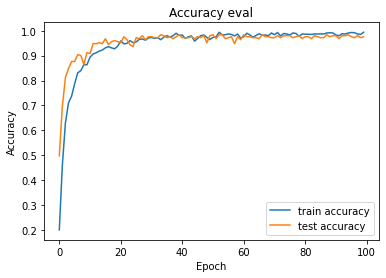

In [ ]:
# create accuracy sublpot
plt.plot(history.history["accuracy"], label="train accuracy")
plt.plot(history.history["val_accuracy"], label="test accuracy")
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy eval")  
plt.show()
# plt.savefig('esc-10-without_any_modif_in_data.png')

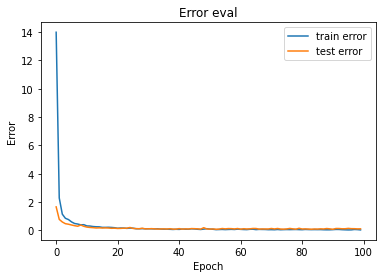

In [ ]:
# create error sublpot
plt.plot(history.history["loss"], label="train error")
plt.plot(history.history["val_loss"], label="test error")
plt.ylabel("Error")
plt.xlabel("Epoch")
plt.legend(loc="upper right")
plt.title("Error eval")
plt.show()
# plt.savefig('esc-10-without_any_modif_in_data_error.png')

In [21]:
import numpy as np
from sklearn.metrics import classification_report,f1_score, accuracy_score
Y_testi = np.argmax(y_test, axis=1) # Convert one-hot to index
y_predi = np.argmax(model.predict(X_test), axis=-1)
print(classification_report(label_classes[Y_testi], label_classes[y_predi]))

NameError: ignored

# **Tensorflow evaluation**

In [24]:
accuracies = []
micro=[]
macro=[]
weighted=[]
f1=np.ndarray((5,num_classes))
times = []
length=5

for model_nr in np.arange(5): 
  DATA_PATH=MODEL_PATH+'/model_{}/'.format(model_nr)

  model_new = keras.models.load_model(MODEL_PATH+'/model_{}/model.h5'.format(model_nr))

  X_test=np.load(DATA_PATH+'X_test.npy')
  y_test=np.load(DATA_PATH+'y_test.npy')
  X_train=np.load(DATA_PATH+'X_train.npy')
  y_train=np.load(DATA_PATH+'y_train.npy') 

  start=time.perf_counter()
  y_pred = np.argmax(model_new.predict(X_test), axis=-1)
  stop=time.perf_counter()-start
  times.append(stop*1000)
  Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
  accuracies.append(accuracy_score(Y_test, y_pred))
  micro.append(f1_score(Y_test, y_pred, average='micro'))
  macro.append(f1_score(Y_test, y_pred, average='macro'))
  weighted.append(f1_score(Y_test, y_pred, average='weighted'))
  f1[model_nr]=(f1_score(Y_test, y_pred, average=None))

print("Accuracy mean, std")
print(np.mean(accuracies)*100)
print(np.std(accuracies)*100)
print("time mean, std (ms)")
print(np.mean(times))
print(np.std(times))
print("Micro f1 mean, std")
print(np.mean(micro))
print(np.std(micro))
print("Macro f1 mean, std")
print(np.mean(macro))
print(np.std(macro))
print("Weighted f1 mean, std")
print(np.mean(weighted))
print(np.std(weighted))
print("f1 multiclass mean, std")
print(f1.mean(axis=0))
print(f1.std(axis=0))

Accuracy mean, std
63.05
1.1768602295939816
time mean, std (ms)
208.51975759999277
7.420042090277791
Micro f1 mean, std
0.6305
0.011768602295939817
Macro f1 mean, std
0.6261329202536444
0.010700284412035663
Weighted f1 mean, std
0.6261329202536444
0.010700284412035663
f1 multiclass mean, std
[0.8223753  0.64761905 0.74833333 0.72908425 0.64069597 0.49370394
 0.75579832 0.83809524 0.75081699 0.74943144 0.75572874 0.73545752
 0.7219716  0.72700747 0.37879336 0.74249226 0.50958908 0.77335165
 0.70760037 0.78314288 0.63486318 0.74790309 0.42323232 0.59761905
 0.63138975 0.48961538 0.63266254 0.70249226 0.50910527 0.60119214
 0.40918473 0.49137305 0.37786378 0.78470588 0.52534632 0.67266968
 0.82681975 0.34849817 0.67403509 0.57099567 0.53121775 0.63663004
 0.64646677 0.46077884 0.53976117 0.71969335 0.44043062 0.71448682
 0.36114797 0.59337682]
[0.06580874 0.11106575 0.0707892  0.15245307 0.06279593 0.15026683
 0.14701185 0.09934023 0.14816397 0.07170069 0.14976939 0.14236016
 0.03608945 0

In [ ]:
f1 = f1_score(Y_testi,y_predi,average=None)
f1_micro = f1_score(Y_testi,y_predi,average='micro')
f1_macro = f1_score(Y_testi,y_predi,average='macro')
f1_weighted = f1_score(Y_testi,y_predi,average='weighted')
print('micro',f1_micro,'macro',f1_macro,'weighted',f1_weighted)

micro 0.6666666666666666 macro 0.6518253968253969 weighted 0.6575837742504409


In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 187, 28)           224       
_________________________________________________________________
maxpooling1d_1 (MaxPooling1D (None, 62, 28)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 57, 36)            6084      
_________________________________________________________________
maxpooling1d_2 (MaxPooling1D (None, 28, 36)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 26, 48)            5232      
_________________________________________________________________
flatten (Flatten)            (None, 1248)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)              

In [ ]:
import tensorflow as tf


# **TFLite evaluation**

In [ ]:
accuracies = []
micro=[]
macro=[]
weighted=[]
f1=np.ndarray((5,10))
times = []
length=5

for model_nr in np.arange(5):
  
  DATA_PATH=MODEL_PATH+'/model_{}/'.format(model_nr)
  TFLITE_PATH=MODEL_PATH+'/model_{}/model.tflite'.format(model_nr)
  
  model_new = keras.models.load_model(MODEL_PATH+'/model_{}/model.h5'.format(model_nr))
  converter = tf.lite.TFLiteConverter.from_keras_model(model_new)
  tflite_model = converter.convert()

  # Save the LITE model to file
  with open(TFLITE_PATH, "wb") as output_file:
      output_file.write(tflite_model)

  interpreter = interpreter = tf.lite.Interpreter(model_path=(TFLITE_PATH))
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()

  output_details = interpreter.get_output_details()
  input_shape = input_details[0]['shape']

  
  X_test=np.load(DATA_PATH+'X_test.npy')
  y_test=np.load(DATA_PATH+'y_test.npy')
  X_train=np.load(DATA_PATH+'X_train.npy')
  y_train=np.load(DATA_PATH+'y_train.npy')
  y_pred=np.zeros(len(X_test))
  acc = 0

  for i in range(len(X_test)):
  # set_input(interpreter, X_test[i])
    input_data = np.array(X_test[i].reshape(input_shape), dtype=np.float32)
    #print(input_data.shape)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    start = time.perf_counter()
    interpreter.invoke()
    inference_time = time.perf_counter() - start
    times.append(inference_time * 1000)
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred[i]=np.argmax(output_data)
    if np.argmax(output_data) == np.argmax(y_test[i]):
      acc += 1
    
  Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
  micro.append(f1_score(Y_test, y_pred, average='micro'))
  macro.append(f1_score(Y_test, y_pred, average='macro'))
  weighted.append(f1_score(Y_test, y_pred, average='weighted'))
  f1[model_nr]=(f1_score(Y_test, y_pred, average=None))
  acc = (acc/len(X_test)) * 100
  accuracies.append(acc)
  
print("Accuracy mean, std")
print(np.mean(accuracies))
print(np.std(accuracies))
print("time mean, std (ms)")
print(np.mean(times))
print(np.std(times))
print("Micro f1 mean, std")
print(np.mean(micro))
print(np.std(micro))
print("Macro f1 mean, std")
print(np.mean(macro))
print(np.std(macro))
print("Weighted f1 mean, std")
print(np.mean(weighted))
print(np.std(weighted))
print("f1 multiclass mean, std")
print(f1.mean(axis=0))
print(f1.std(axis=0))

INFO:tensorflow:Assets written to: /tmp/tmphlg9nxcj/assets


INFO:tensorflow:Assets written to: /tmp/tmphlg9nxcj/assets


INFO:tensorflow:Assets written to: /tmp/tmp37kkcpos/assets


INFO:tensorflow:Assets written to: /tmp/tmp37kkcpos/assets


INFO:tensorflow:Assets written to: /tmp/tmpdzpy4nza/assets


INFO:tensorflow:Assets written to: /tmp/tmpdzpy4nza/assets


INFO:tensorflow:Assets written to: /tmp/tmpnvebwau0/assets


INFO:tensorflow:Assets written to: /tmp/tmpnvebwau0/assets


INFO:tensorflow:Assets written to: /tmp/tmpc2_w1ccx/assets


INFO:tensorflow:Assets written to: /tmp/tmpc2_w1ccx/assets


Accuracy mean, std
63.88888888888889
4.648111258522638
time mean, std (ms)
0.1124573944707663
0.05356445783156213
Micro f1 mean, std
0.6388888888888888
0.046481112585226386
Macro f1 mean, std
0.6136825396825397
0.04043015122083995
Weighted f1 mean, std
0.6167372134038801
0.04321793692592351
f1 multiclass mean, std
[0.72761905 0.84761905 0.79142857 0.79285714 0.43777778 0.53777778
 0.52428571 0.52539683 0.47428571 0.47777778]
[0.15737069 0.10605265 0.16303249 0.16659863 0.37996751 0.31752126
 0.13011769 0.08464947 0.30554735 0.17777778]


In [ ]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((X_train)).batch(1).take(100):
    yield [tf.dtypes.cast(data, tf.float32)]

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: protobuf, wheel, tensorflow-estimator, grpcio, absl-py, google-pasta, astunparse, gast, tensorboard, keras-preprocessing, typing-extensions, flatbuffers, six, termcolor, opt-einsum, h5py, wrapt, numpy
Required-by: fancyimpute


# **Quantized TFLite evaluation (post training quantization, 8bit)**

In [ ]:
accuracies = []
micro=[]
macro=[]
weighted=[]
f1=np.ndarray((5,10))
times = []
length=5

for model_nr in np.arange(5):  
  DATA_PATH=MODEL_PATH+'/model_{}/'.format(model_nr)
  TFLITE_PATH=MODEL_PATH+'/model_{}/model.tflite'.format(model_nr)
  QUANTIZED_TFLITE_PATH=MODEL_PATH+'/model_{}/quantmodel.tflite'.format(model_nr)
  # load the previously saved model
  model_new = keras.models.load_model(MODEL_PATH+'/model_{}/model.h5'.format(model_nr))
  converter = tf.lite.TFLiteConverter.from_keras_model(model_new)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.representative_dataset = representative_dataset
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.target_spec.supported_types = [tf.int8]
  converter.inference_input_type = tf.int8
  converter.inference_output_type = tf.int8
  converter.experimental_new_converter=True

  X_test=np.load(DATA_PATH+'X_test.npy')
  y_test=np.load(DATA_PATH+'y_test.npy')
  X_train=np.load(DATA_PATH+'X_train.npy')
  y_train=np.load(DATA_PATH+'y_train.npy')

  y_pred=np.zeros(len(X_test)) 
  tflite_model = converter.convert()

  # Save the model to file
  with open(QUANTIZED_TFLITE_PATH, "wb") as output_file:
    output_file.write(tflite_model)
  
  acc = 0
  y_pred=np.zeros(len(X_test))

  interpreter = interpreter = tf.lite.Interpreter(model_path=(QUANTIZED_TFLITE_PATH))
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  input_shape = input_details[0]['shape']
  for i in range(len(X_test)):
#       set_input(interpreter, x_test[i])
      input_data = X_test[i].reshape(input_shape).astype(np.int8)
      #input_data = input_data.astype(np.float32)
      interpreter.set_tensor(input_details[0]['index'], input_data)
      start = time.perf_counter()
      interpreter.invoke()
      inference_time = time.perf_counter() - start
      times.append(inference_time * 1000)
      output_data = interpreter.get_tensor(output_details[0]['index'])
      y_pred[i]=np.argmax(output_data)
      if np.argmax(output_data) == np.argmax(y_test[i]):
          acc += 1

  Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
  micro.append(f1_score(Y_test, y_pred, average='micro'))
  macro.append(f1_score(Y_test, y_pred, average='macro'))
  weighted.append(f1_score(Y_test, y_pred, average='weighted'))
  f1[model_nr]=(f1_score(Y_test, y_pred, average=None))
  acc = (acc/len(X_test)) * 100
  accuracies.append(acc)
  Y_test = np.argmax(y_test, axis=1)

print("Accuracy mean, std")
print(np.mean(accuracies))
print(np.std(accuracies))
print("time mean, std (ms)")
print(np.mean(times))
print(np.std(times))
print("Micro f1 mean, std")
print(np.mean(micro))
print(np.std(micro))
print("Macro f1 mean, std")
print(np.mean(macro))
print(np.std(macro))
print("Weighted f1 mean, std")
print(np.mean(weighted))
print(np.std(weighted))
print("f1 multiclass mean, std")
print(f1.mean(axis=0))
print(f1.std(axis=0))

INFO:tensorflow:Assets written to: /tmp/tmpjfprpm87/assets


INFO:tensorflow:Assets written to: /tmp/tmpjfprpm87/assets


INFO:tensorflow:Assets written to: /tmp/tmp6bq_uj8i/assets


INFO:tensorflow:Assets written to: /tmp/tmp6bq_uj8i/assets


INFO:tensorflow:Assets written to: /tmp/tmpwuf5quua/assets


INFO:tensorflow:Assets written to: /tmp/tmpwuf5quua/assets


INFO:tensorflow:Assets written to: /tmp/tmp3gnvbr3h/assets


INFO:tensorflow:Assets written to: /tmp/tmp3gnvbr3h/assets


INFO:tensorflow:Assets written to: /tmp/tmp_d_carh_/assets


INFO:tensorflow:Assets written to: /tmp/tmp_d_carh_/assets


Accuracy mean, std
9.999999999999996
2.2222222222222228
time mean, std (ms)
1.6680012611206823
0.16199135979611454
Micro f1 mean, std
0.09999999999999999
0.022222222222222227
Macro f1 mean, std
0.029439929254170737
0.02305549189900422
Weighted f1 mean, std
0.02894244545431336
0.02521173574253461
f1 multiclass mean, std
[0.03157895 0.03243243 0.         0.         0.11428571 0.03636364
 0.         0.07973856 0.         0.        ]
[0.06315789 0.06486486 0.         0.         0.22857143 0.07272727
 0.         0.09872527 0.         0.        ]


# **Quantization aware training**

In [ ]:
! pip install -q tensorflow-model-optimization

     |████████████████████████████████| 174kB 7.7MB/s 


In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_model_optimization as tfmot

In [ ]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=7)
cvscores = []
Prediction_time_liste = []
fold = 0
model_nr=0
for train, test in kf.split(X,y):#scaler = X
    fold+=1
    print(f"Fold #{fold}")
        
#    X_train = X.to_numpy()[train]
    X_train =  X.to_numpy()[train]
    y_train = y.to_numpy()[train]
    X_test =  X.to_numpy()[test]
    y_test = y.to_numpy()[test]

    # Architecture
    model = keras.Sequential()

    # 1st conv layer

    model.add(Conv2D(28, (7, 1), name='conv2d_1', activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001),input_shape = (193, 1, 1)))
    model.add(MaxPooling2D((3, 1), name='maxpooling2d_1'))
    # 2nd conv layer

    model.add(Conv2D(36, (6,1), name='conv2d_2', activation='relu',padding='valid', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
    model.add(MaxPooling2D((2, 1), name='maxpooling2d_2'))
    # 3nd conv layer
    # model.add(Dropout(0.5))

    model.add(Conv2D(48, (3, 1), name='conv2d_3', activation='relu',padding='valid'))
    model.add(Flatten(name='flatten'))


    # 4nd conv layer

    model.add(Dense(20, name='dense_1', activation='relu'))
    model.add(Dropout(0.5, name='dropout'))

    model.add(Dense(10, name='dense_2', activation='softmax'))

    #Quantization aware training
    quantize_model = tfmot.quantization.keras.quantize_model

    # q_aware stands for for quantization aware.
    model = quantize_model(model)

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  
    y_train = keras.utils.to_categorical(y_train - 1, num_classes=10) # Converts a class vector (integers) to binary class matrix
    y_test = keras.utils.to_categorical(y_test - 1, num_classes=10)
  
    X_train = np.expand_dims(X_train, axis=2) # Make 2-dim into 3-dim array to fit model
    X_test = np.expand_dims(X_test, axis=2)
    X_train = np.expand_dims(X_train, axis=3) # Make 2-dim into 3-dim array to fit model
    X_test = np.expand_dims(X_test, axis=3)
    print(X_train.shape)
    model.summary()
#     monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train,epochs=100, verbose=2,validation_data=(X_test, y_test))  

    
    if not os.path.exists(MODEL_PATH+'/qawmodel_{}'.format(model_nr)):
      os.makedirs(MODEL_PATH+'/qawmodel_{}'.format(model_nr))
    model.save(MODEL_PATH+'/qawmodel_{}/qawmodel.h5'.format(model_nr)) 
    np.save(MODEL_PATH+'/qawmodel_{}/X_train.npy'.format(model_nr),X_train)
    np.save(MODEL_PATH+'/qawmodel_{}/y_train.npy'.format(model_nr),y_train)
    np.save(MODEL_PATH+'/qawmodel_{}/X_test.npy'.format(model_nr),X_test)
    np.save(MODEL_PATH+'/qawmodel_{}/y_test.npy'.format(model_nr),y_test)

    model_nr+=1

#   monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)
    start_pr = time.clock()
    scores = model.evaluate(X_test, y_test, verbose=0) # Computes the loss & accuracy based on the input you pass it
    end_pr = time.clock()
    Prediction_time = (end_pr - start_pr)*1000
    Prediction_time = Prediction_time/len(X_test)
    print(f"Prediction time: {Prediction_time_liste.append(Prediction_time)}ms")
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print("value of Prediction total:{}, value of std_Prediction:{}".format(np.mean(Prediction_time_liste), np.std(Prediction_time_liste)))
    


Fold #1
(144, 193, 1, 1)
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_1 (QuantizeLa (None, 193, 1, 1)         3         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 187, 1, 28)        283       
_________________________________________________________________
quant_maxpooling2d_1 (Quanti (None, 62, 1, 28)         1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 57, 1, 36)         6159      
_________________________________________________________________
quant_maxpooling2d_2 (Quanti (None, 28, 1, 36)         1         
_________________________________________________________________
quant_conv2d_3 (QuantizeWrap (None, 26, 1, 48)         5331      
_________________________________________________________________
quant_flatten (QuantizeWrapp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


(144, 193, 1, 1)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_2 (QuantizeLa (None, 193, 1, 1)         3         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 187, 1, 28)        283       
_________________________________________________________________
quant_maxpooling2d_1 (Quanti (None, 62, 1, 28)         1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 57, 1, 36)         6159      
_________________________________________________________________
quant_maxpooling2d_2 (Quanti (None, 28, 1, 36)         1         
_________________________________________________________________
quant_conv2d_3 (QuantizeWrap (None, 26, 1, 48)         5331      
_________________________________________________________________
quant_flatten (QuantizeWrapp (None, 

In [ ]:
accuracies = []
micro=[]
macro=[]
weighted=[]
f1=np.ndarray((5,10))
times = []
length=5

for model_nr in np.arange(5): 
  QAW_MODEL_PATH=MODEL_PATH+'/qawmodel_{}/qawmodel.h5'.format(model_nr)
  DATA_PATH=MODEL_PATH+'/qawmodel_{}/'.format(model_nr)

  with tfmot.quantization.keras.quantize_scope():
      model_new = tf.keras.models.load_model(QAW_MODEL_PATH)

  X_test=np.load(DATA_PATH+'X_test.npy')
  y_test=np.load(DATA_PATH+'y_test.npy')
  X_train=np.load(DATA_PATH+'X_train.npy')
  y_train=np.load(DATA_PATH+'y_train.npy') 

  y_pred=np.zeros(len(X_test))

  start=time.perf_counter()
  y_pred = np.argmax(model_new.predict(X_test), axis=-1)
  stop=time.perf_counter()-start
  times.append(stop*1000)
  Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
  accuracies.append(accuracy_score(Y_test, y_pred))
  micro.append(f1_score(Y_test, y_pred, average='micro'))
  macro.append(f1_score(Y_test, y_pred, average='macro'))
  weighted.append(f1_score(Y_test, y_pred, average='weighted'))
  f1[model_nr]=(f1_score(Y_test, y_pred, average=None))

print("Accuracy mean, std")
print(np.mean(accuracies)*100)
print(np.std(accuracies)*100)
print("time mean, std (ms)")
print(np.mean(times))
print(np.std(times))
print("Micro f1 mean, std")
print(np.mean(micro))
print(np.std(micro))
print("Macro f1 mean, std")
print(np.mean(macro))
print(np.std(macro))
print("Weighted f1 mean, std")
print(np.mean(weighted))
print(np.std(weighted))
print("f1 multiclass mean, std")
print(f1.mean(axis=0))
print(f1.std(axis=0))

Accuracy mean, std
49.999999999999986
4.969039949999534
time mean, std (ms)
167.53703619997395
6.424531467349851
Micro f1 mean, std
0.4999999999999999
0.04969039949999533
Macro f1 mean, std
0.4782460317460318
0.05041054931247414
Weighted f1 mean, std
0.47673721340388003
0.05468205439426161
f1 multiclass mean, std
[0.59920635 0.77142857 0.73333333 0.53238095 0.64       0.43873016
 0.25142857 0.16388889 0.42539683 0.22666667]
[0.2076273  0.16381921 0.19776529 0.1817626  0.22449944 0.07782376
 0.2245358  0.14497765 0.22857143 0.18666667]


In [ ]:
for model_nr in np.arange(5):  
  QAW_MODEL_PATH=MODEL_PATH+'/qawmodel_{}/qawmodel.h5'.format(model_nr)
  DATA_PATH=MODEL_PATH+'/qawmodel_{}/'.format(model_nr)
  QAW_TFLITE_PATH=MODEL_PATH+'/qawmodel_{}/qawmodel.tflite'.format(model_nr)
  QAW_QUANTIZED_TFLITE_PATH=MODEL_PATH+'/qawmodel_{}/quant_qawmodel.tflite'.format(model_nr)
  with tfmot.quantization.keras.quantize_scope():
      model = tf.keras.models.load_model(QAW_MODEL_PATH)
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert()
  # Save the LITE model to file
  with open(QAW_TFLITE_PATH, "wb") as output_file:
      output_file.write(tflite_model)
  # load the previously saved model
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  #converter.representative_dataset = get_representative_dataset_gen(x_train)
  #converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  #converter.target_spec.supported_types = [tf.int8]
  #converter.inference_input_type = tf.int8
  #converter.inference_output_type = tf.int8
  tflite_model = converter.convert()
  # Save the quantized lite model to file
  with open(QAW_QUANTIZED_TFLITE_PATH, "wb") as output_file:
      output_file.write(tflite_model) 

INFO:tensorflow:Assets written to: /tmp/tmpplqff_3j/assets


INFO:tensorflow:Assets written to: /tmp/tmpplqff_3j/assets


INFO:tensorflow:Assets written to: /tmp/tmpvn7_xnd0/assets


INFO:tensorflow:Assets written to: /tmp/tmpvn7_xnd0/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ur2vv4k/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ur2vv4k/assets


INFO:tensorflow:Assets written to: /tmp/tmpfgmtacxb/assets


INFO:tensorflow:Assets written to: /tmp/tmpfgmtacxb/assets


INFO:tensorflow:Assets written to: /tmp/tmpkzx7adxa/assets


INFO:tensorflow:Assets written to: /tmp/tmpkzx7adxa/assets


INFO:tensorflow:Assets written to: /tmp/tmpleagar9g/assets


INFO:tensorflow:Assets written to: /tmp/tmpleagar9g/assets


INFO:tensorflow:Assets written to: /tmp/tmpjc7y7fyt/assets


INFO:tensorflow:Assets written to: /tmp/tmpjc7y7fyt/assets


INFO:tensorflow:Assets written to: /tmp/tmp7vjp0c15/assets


INFO:tensorflow:Assets written to: /tmp/tmp7vjp0c15/assets


INFO:tensorflow:Assets written to: /tmp/tmpqfub89q5/assets


INFO:tensorflow:Assets written to: /tmp/tmpqfub89q5/assets


INFO:tensorflow:Assets written to: /tmp/tmpurvmcs3c/assets


INFO:tensorflow:Assets written to: /tmp/tmpurvmcs3c/assets


# **Quantized TFLite evaluation (quantization aware trained)**

In [ ]:
accuracies = []
micro=[]
macro=[]
weighted=[]
f1=np.ndarray((5,10))
times = []
length=5

for model_nr in np.arange(5):  
  QAW_QUANTIZED_TFLITE_PATH=MODEL_PATH+'/qawmodel_{}/quant_qawmodel.tflite'.format(model_nr)
  DATA_PATH=MODEL_PATH+'/qawmodel_{}/'.format(model_nr)
  interpreter = interpreter = tf.lite.Interpreter(model_path=(QAW_QUANTIZED_TFLITE_PATH))
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  input_shape = input_details[0]['shape']

  X_test=np.load(DATA_PATH+'X_test.npy')
  y_test=np.load(DATA_PATH+'y_test.npy')
  X_train=np.load(DATA_PATH+'X_train.npy')
  y_train=np.load(DATA_PATH+'y_train.npy')  

  y_pred=np.zeros(len(X_test))

  for i in range(len(X_test)):
    input_data = X_test[i].reshape(input_shape).astype(np.float32)
    #input_data = input_data.astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    start = time.perf_counter()
    interpreter.invoke()
    inference_time = time.perf_counter() - start
    times.append(inference_time * 1000)
    output_data = interpreter.get_tensor(output_details[0]['index'])
    y_pred[i]=np.argmax(output_data)
    if np.argmax(output_data) == np.argmax(y_test[i]):
        acc += 1

  acc = (acc/len(X_test)) * 100
  Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
  accuracies.append(accuracy_score(Y_test, y_pred))
  micro.append(f1_score(Y_test, y_pred, average='micro'))
  macro.append(f1_score(Y_test, y_pred, average='macro'))
  weighted.append(f1_score(Y_test, y_pred, average='weighted'))
  f1[model_nr]=(f1_score(Y_test, y_pred, average=None))

print("Accuracy mean, std")
print(np.mean(accuracies)*100)
print(np.std(accuracies)*100)
print("time mean, std (ms)")
print(np.mean(times))
print(np.std(times))
print("Micro f1 mean, std")
print(np.mean(micro))
print(np.std(micro))
print("Macro f1 mean, std")
print(np.mean(macro))
print(np.std(macro))
print("Weighted f1 mean, std")
print(np.mean(weighted))
print(np.std(weighted))
print("f1 multiclass mean, std")
print(f1.mean(axis=0))
print(f1.std(axis=0))

Accuracy mean, std
49.444444444444436
4.779069592801459
time mean, std (ms)
1.6785188499776875
0.16154394512816914
Micro f1 mean, std
0.49444444444444435
0.0477906959280146
Macro f1 mean, std
0.4706904761904762
0.04800128074213082
Weighted f1 mean, std
0.47019400352733687
0.05027411222828341
f1 multiclass mean, std
[0.59920635 0.77142857 0.73333333 0.53238095 0.64       0.43873016
 0.25142857 0.16388889 0.41650794 0.16      ]
[0.2076273  0.16381921 0.19776529 0.1817626  0.22449944 0.07782376
 0.2245358  0.14497765 0.22852204 0.19595918]
